In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   sklearn.compose            import *
from   sklearn.ensemble           import RandomForestRegressor
from   sklearn.experimental       import enable_iterative_imputer
from   sklearn.impute             import *
from   sklearn.linear_model       import *
from   sklearn.pipeline           import Pipeline
from   sklearn.preprocessing      import *
from   sklearn.base               import BaseEstimator
from   sklearn.model_selection    import RandomizedSearchCV
from   sklearn.inspection         import permutation_importance
from   sklearn.metrics            import mean_absolute_error
from   sklearn.model_selection    import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load in data
cbb = pd.read_csv('kaggle-cbb/cbb.csv')
cbb.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


In [3]:
# Estimator to be used in RandomizedSearch later
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

# Splitting data with train/valid = '15, '16, '17 season and test = '18 season

The 2019 season has two extra teams added in. To have the most consistent train/validation/test sets, we will only consider the 2015-2018 seasons where we will train on the 2015-2017 seasons and use the 2018 season as our test data.

In [4]:
df = cbb[~(cbb.YEAR == 2019)]  # Removing rows associated with the 2019 season

train = df[~(df.YEAR == 2018)]  # Create train set with data associated with 2015-2017 seasons
test = df[df.YEAR == 2018]  # Create test set with data associated with 2018 season

# Train/Validation data

Here we will create a "universal" train/validation split that each model search will use for consistency.

In [5]:
features = train.columns[4:-4]  # Only keeping columns with team stats and removing columns related to postseason/rank
                                # or team name/conference
X = train[features]
y = train['W']  # Target variable "wins"

In [6]:
# Creating the same train/validation sets to be used across each model to compare the best to use for our final model
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

# Four Factors

"Four Factors of Basketball Success" from Dean Oliver involves the following 8 variables:

(1) EFG_O: Effective Field Goal Percentage Shot, 
(2) EFG_D: Effective Field Goal Percentage Allowed,
(3) TOR: Turnover Percentage Allowed (Turnover Rate), 
(4) TORD: Turnover Percentage Committed (Steal Rate),
(5) ORB: Offensive Rebound Rate, 
(6) DRB: Offensive Rebound Rate Allowed,
(7) FTR : Free Throw Rate (How often the given team shoots Free Throws), 
(8) FTRD: Free Throw Rate Allowed

In [7]:
# Grab the 8 columns that are part of the "Four Factors of Basketball Success"
ff_train = X_train[['EFG_O','EFG_D','TOR','TORD','ORB','DRB','FTR','FTRD']]
ff_val = X_val[['EFG_O','EFG_D','TOR','TORD','ORB','DRB','FTR','FTRD']]

In [25]:
# Pipeline and RandomizedSearch to find the best regression model where each hyperparameter that is part of the search
# is one that can affect the coefficients for the features depending on the linear model.
pipe = Pipeline([('scaler',StandardScaler()),
                 ('reg',DummyEstimator())])

search_space = [{'reg': [LinearRegression(n_jobs=-1)] # Actual Estimator
                },
                
                {'reg': [Lasso()],  # Actual Estimator
                 'reg__alpha': np.arange(0.1,1,0.1),
                 'reg__max_iter': np.arange(100, 1000, 100),
                },
                
                {'reg': [Ridge()],  # Actual Estimator
                 'reg__alpha': np.arange(0.1, 1, 0.1),
                 'reg__max_iter': np.arange(100, 1000, 100)
                },
                
                {'reg': [SGDRegressor()],  # Actual Estimator
                 'reg__penalty': ['l2', 'l1', 'elasticnet'],
                 'reg__alpha': np.arange(0.0001, 1, 0.1),
                 'reg__max_iter': np.arange(100, 1000, 100),
                 'reg__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
                },
                
                {'reg': [ElasticNet()],  # Actual Estimator
                 'reg__alpha': np.arange(0.1, 1, 0.1),
                 'reg__l1_ratio': np.arange(0, 1.1, 0.1),
                 'reg__max_iter': np.arange(100, 1000, 100),
                 'reg__selection': ['cyclic', 'random']
                },
                
                {'reg': [RandomForestRegressor(n_jobs=-1)],  # Actual Estimator
                 'reg__criterion': ['mse', 'mae'],
                 'reg__n_estimators': np.arange(100, 1000, 150),
                 'reg__max_features': ['log2','sqrt'],
                 'reg__max_depth' : np.arange(15,25,1),
                 'reg__min_samples_leaf': np.arange(1,10,1)
                }
                 ]

reg_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=100,
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1,
                                    scoring='neg_mean_absolute_error',
                                    random_state=1)

In [26]:
# Print out the best model from our search
ff_model = reg_algos_rand.fit(ff_train, y_train)
print(ff_model.best_estimator_)
print(ff_model.best_estimator_.get_params()['reg'])
print(ff_model.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Pipeline(steps=[('Sca', StandardScaler()),
                ('reg',
                 SGDRegressor(alpha=0.10010000000000001,
                              learning_rate='adaptive', max_iter=300,
                              penalty='l1'))])
SGDRegressor(alpha=0.10010000000000001, learning_rate='adaptive', max_iter=300,
             penalty='l1')
-1.9547902774576689


Looks like SGDRegressor performed the best with an MAE of 1.943 on the train set. Let's have a look at the hyperparameters.

In [27]:
ff_model.best_estimator_['reg'].get_params()

{'alpha': 0.10010000000000001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'adaptive',
 'loss': 'squared_loss',
 'max_iter': 300,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### Validation performance with this best model

In [55]:
# Fitting the model to evaluate its performance on the validation set
params_ff = {'alpha': 0.10010000000000001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'adaptive',
 'loss': 'squared_loss',
 'max_iter': 300,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

pipe_ff = Pipeline(steps=[('scaler',StandardScaler()), ('reg', SGDRegressor(**params_ff))])
pipe_ff.fit(ff_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 SGDRegressor(alpha=0.10010000000000001,
                              learning_rate='adaptive', max_iter=300,
                              penalty='l1'))])

In [56]:
# Evaluating on validation set
y_pred = pipe_ff.predict(ff_val)
ff_mae = mean_absolute_error(y_val, y_pred)
print(f"MAE: {ff_mae:.6f}")

MAE: 2.024424


# Adjusted Efficiency Stats

In [22]:
# Grab the 3 columns that have the adjusted efficiency stats
adj_train = X_train[['ADJOE', 'ADJDE', 'ADJ_T']]
adj_val = X_val[['ADJOE', 'ADJDE', 'ADJ_T']]

In [30]:
# Pipeline and RandomizedSearch to find the best regression model where each hyperparameter that is part of the search
# is one that can affect the coefficients for the features depending on the linear model.
pipe = Pipeline([('scaler',StandardScaler()),
                 ('reg',DummyEstimator())])

search_space = [{'reg': [LinearRegression(n_jobs=-1)] # Actual Estimator
                },
                
                {'reg': [Lasso()],  # Actual Estimator
                 'reg__alpha': np.arange(0.1,1,0.1),
                 'reg__max_iter': np.arange(100, 1000, 100),
                },
                
                {'reg': [Ridge()],  # Actual Estimator
                 'reg__alpha': np.arange(0.1, 1, 0.1),
                 'reg__max_iter': np.arange(100, 1000, 100)
                },
                
                {'reg': [SGDRegressor()],  # Actual Estimator
                 'reg__penalty': ['l2', 'l1', 'elasticnet'],
                 'reg__alpha': np.arange(0.0001, 1, 0.1),
                 'reg__max_iter': np.arange(100, 1000, 100),
                 'reg__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
                },
                
                {'reg': [ElasticNet()],  # Actual Estimator
                 'reg__alpha': np.arange(0.1, 1, 0.1),
                 'reg__l1_ratio': np.arange(0, 1.1, 0.1),
                 'reg__max_iter': np.arange(100, 1000, 100),
                 'reg__selection': ['cyclic', 'random']
                },
                
                {'reg': [RandomForestRegressor(n_jobs=-1)],  # Actual Estimator
                 'reg__criterion': ['mse', 'mae'],
                 'reg__n_estimators': np.arange(100, 1000, 150),
                 'reg__max_features': ['log2','sqrt'],
                 'reg__max_depth' : np.arange(15,25,1),
                 'reg__min_samples_leaf': np.arange(1,10,1)
                }
                 ]

reg_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=100,
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1,
                                    scoring='neg_mean_absolute_error',
                                    random_state=2)

In [31]:
# Print out the best model from our search
adj_model = reg_algos_rand.fit(adj_train, y_train)
print(adj_model.best_estimator_)
print(adj_model.best_estimator_.get_params()['reg'])
print(adj_model.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Pipeline(steps=[('Sca', StandardScaler()),
                ('reg', SGDRegressor(max_iter=100, penalty='l1'))])
SGDRegressor(max_iter=100, penalty='l1')
-2.9168737201327644


In [32]:
adj_model.best_estimator_['reg'].get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 100,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [52]:
# Fitting the model to evaluate its performance on the validation set
params_adj = {'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 100,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

pipe_adj = Pipeline(steps=[('scaler',StandardScaler()), ('reg', SGDRegressor(**params_adj))])
pipe_adj.fit(adj_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', SGDRegressor(max_iter=100, penalty='l1'))])

In [53]:
# Evaluating on validation set
y_pred = pipe_adj.predict(adj_val)
adj_mae = mean_absolute_error(y_val, y_pred)
print(f"MAE: {adj_mae:.6f}")

MAE: 2.969556


# All stats

In [46]:
# Pipeline and RandomizedSearch to find the best regression model where each hyperparameter that is part of the search
# is one that can affect the coefficients for the features depending on the linear model.
pipe = Pipeline([('scaler',StandardScaler()),
                 ('reg',DummyEstimator())])

search_space = [{'reg': [LinearRegression(n_jobs=-1)] # Actual Estimator
                },
                
                {'reg': [Lasso()],  # Actual Estimator
                 'reg__alpha': np.arange(0.1,1,0.1),
                 'reg__max_iter': np.arange(100, 1000, 100),
                },
                
                {'reg': [Ridge()],  # Actual Estimator
                 'reg__alpha': np.arange(0.1, 1, 0.1),
                 'reg__max_iter': np.arange(100, 1000, 100)
                },
                
                {'reg': [SGDRegressor()],  # Actual Estimator
                 'reg__penalty': ['l2', 'l1', 'elasticnet'],
                 'reg__alpha': np.arange(0.0001, 1, 0.1),
                 'reg__max_iter': np.arange(100, 1000, 100),
                 'reg__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
                },
                
                {'reg': [ElasticNet()],  # Actual Estimator
                 'reg__alpha': np.arange(0.1, 1, 0.1),
                 'reg__l1_ratio': np.arange(0, 1.1, 0.1),
                 'reg__max_iter': np.arange(100, 1000, 100),
                 'reg__selection': ['cyclic', 'random']
                },
                
                {'reg': [RandomForestRegressor(n_jobs=-1)],  # Actual Estimator
                 'reg__criterion': ['mse', 'mae'],
                 'reg__n_estimators': np.arange(100, 1000, 150),
                 'reg__max_features': ['log2','sqrt'],
                 'reg__max_depth' : np.arange(15,25,1),
                 'reg__min_samples_leaf': np.arange(1,10,1)
                }
                 ]

reg_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=100,
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1,
                                    scoring='neg_mean_absolute_error',
                                    random_state=3)

In [47]:
# Print out the best model from our search
all_model = reg_algos_rand.fit(X_train, y_train)
print(all_model.best_estimator_)
print(all_model.best_estimator_.get_params()['reg'])
print(all_model.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Pipeline(steps=[('Sca', StandardScaler()),
                ('reg', Ridge(alpha=0.2, max_iter=300))])
Ridge(alpha=0.2, max_iter=300)
-1.924084758809625


In [48]:
all_model.best_estimator_['reg'].get_params()

{'alpha': 0.2,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 300,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [57]:
# Fitting the model to evaluate its performance on the validation set
params_all = {'alpha': 0.2,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 300,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

pipe_all = Pipeline(steps=[('scaler',StandardScaler()), ('reg', Ridge(**params_all))])
pipe_all.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', Ridge(alpha=0.2, max_iter=300))])

In [58]:
# Evaluating on validation set
y_pred = pipe_all.predict(X_val)
all_mae = mean_absolute_error(y_val, y_pred)
print(f"MAE: {all_mae:.6f}")

MAE: 1.963655


Among the 3 different models we fitted, the best model was the Ridge model that was trained using all of the team stats columns with an MAE of 1.96 on the validation set. We will use this model on our test set and see how it does. But out of curiosity, let's have a look at the feature importance of this model before we test it.

# Feature Importance of Best Model

In [59]:
# Use permutation importance to get a sense for the feature importance of our winning model
r = permutation_importance(pipe_all, 
                           X_val, y_val, # Using the validation set makes it possible to highlight which features 
                                         # contribute the most to the generalization power of the inspected model. 
                           n_repeats=100,
                           random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    print(f"{features[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" ± {r.importances_std[i]:.3f}")

EFG_O   0.684 ± 0.043
EFG_D   0.597 ± 0.046
TORD    0.174 ± 0.018
ORB     0.069 ± 0.010
DRB     0.067 ± 0.010
2P_O    0.065 ± 0.009
TOR     0.064 ± 0.009
FTRD    0.054 ± 0.007
ADJOE   0.041 ± 0.006
2P_D    0.032 ± 0.006
3P_O    0.012 ± 0.004
ADJDE   0.011 ± 0.003
FTR     0.007 ± 0.003
ADJ_T   0.007 ± 0.002
BARTHAG 0.001 ± 0.001
3P_D    0.001 ± 0.001


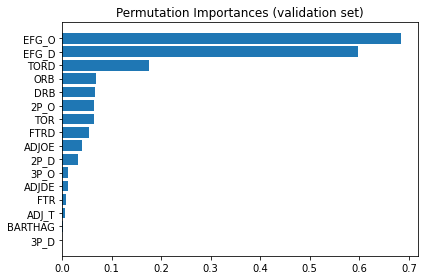

In [61]:
# Barplot visual of the permutation importances
sorted_idx = r.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_val.columns[sorted_idx], r.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

Considering that our model where we fit the columns related to the "Four Factors of Basketball Success" was the second best model of the three we fitted, it does not seem surprising to see those columns have some higher importance among all of the stats. And probably not surprising at all, the effective field goal percentage on offense and defense are the top two features according to the model. One interesting feature that does not seem too important in this model is BARTHAG, which is a measure of the chance a team has of beating an average Division 1 team.

# Testing our Best Model

In [62]:
# Pulling the same features columns from our test data that our best model was fitted on
X_test = test[features]
y_test = test['W']

In [63]:
# Best model
pipe_all

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', Ridge(alpha=0.2, max_iter=300))])

In [65]:
# Fit model on all the available training data
pipe_all.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', Ridge(alpha=0.2, max_iter=300))])

In [66]:
# Testing the model
y_pred = pipe_all.predict(X_test)
all_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {all_mae:.6f}")

MAE: 1.934566


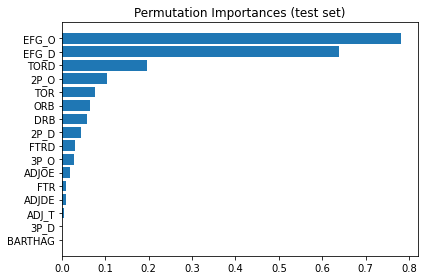

In [74]:
# Feature importance of the model on the test data
r = permutation_importance(pipe_all, 
                           X_test, y_test,
                           n_repeats=100,
                           random_state=42)

sorted_idx = r.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], r.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

From the permutation importance, the top two features remain the same with effective field goal percentage on offense and defense. There is some shuffling of the features compared to the validation set earlier. Notably here BARTHAG is the least important to this model, which brings to question whether this power rating is a true indicator of how "successful" a team will be during the season. Of course, here we are defining success as total number of wins.

# Conclusion

Our best model performed even slightly better than it did on the validation set from earlier with an MAE of 1.93. By using all of the available stats columns of each team, we can predict their respective wins by just within 2 games, which is pretty respectable considering the many factors that go into a college basketball season. This also highlights how we need to make use of all of the data available on teams to make accurate predictions of their potential success, in this case number of wins being the measure of success.